# 利用logistic regression 和 neural network实现手写数据集识别

## 1.数据准备阶段

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
def loadData(filePath,transpose=True):
    data = sio.loadmat(filePath)
    y = data['y']  #(5000,1)的array
    y = y.flatten()  #(5000,)的一维array
    X = data['X'] #(5000,400)的array，但其中的400转换成(20,20)任需要再转置才能正常绘图

    if transpose == True:
        X = np.array([img.reshape(20,20).T for img in X]) #(5000,20,20)
        X = np.array([img.flatten() for img in X])
    return X,y
filePath = './ex3data1.mat'

X,y = loadData(filePath)
print('X.shape:',X.shape)
print('y.shape:',y.shape)


X.shape: (5000, 400)
y.shape: (5000,)


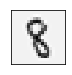

this is a 8 figure.


In [3]:
def plot_one_img(X):
    m = X.shape[0]
    number = np.random.randint(0,m)
    fig,ax = plt.subplots(figsize=(1,1))
    ax.matshow(X[number].reshape(20,20),cmap=matplotlib.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print('this is a',y[number],'figure.')
    return None
plot_one_img(X)
    

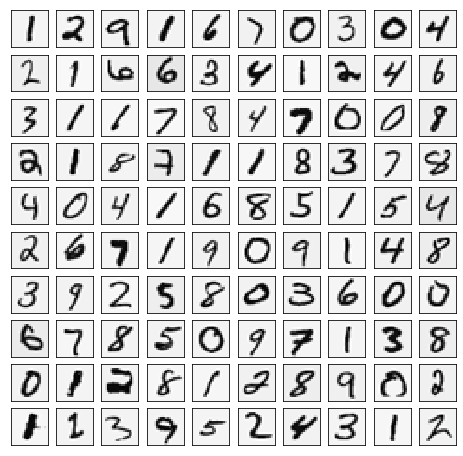

In [4]:
def plot_100_img(X):
    m = X.shape[0]
    numble_idx = np.random.choice(np.arange(m),100)
    sample_img = X[numble_idx,:]
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_img[r*10+c,:].reshape(20,20),cmap=matplotlib.cm.binary)
            plt.xticks([])
            plt.yticks([])
    plt.show()
    return None
plot_100_img(X)

## 2. 生成一对多的标签数据

In [5]:
y_matrix = []
for label in range(1,11):
    y_matrix.append((y==label).astype(int))

#此时y_matrix列表中标签为0(标签值为10)排在最后，应该提前为首元素
y_matrix = [y_matrix[-1]] + y_matrix[:-1]  #列表的拼接
y = np.array(y_matrix)
print('构建的1对多标签y的shape:',y.shape)
print(y[:,1:5])

#为X扩充一纵维(5000,1)的one向量
X_hat = np.c_[X,np.ones((5000,1))]
print('构建的特征X_hat的shape:',X_hat.shape)

构建的1对多标签y的shape: (10, 5000)
[[1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
构建的特征X_hat的shape: (5000, 401)


## 3.Train 10 losigtic regression models with regularization

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

sigmoid(0)

0.5

In [7]:
def regularized_cost(theta,X,y,l):
    m = X.shape[0]
    y = y.reshape(-1,1)
    y_pre = sigmoid(np.dot(X,theta)) #(m,1)
    cost = -(np.dot(y.T,np.log(y_pre))[0] + np.dot((1-y).T,np.log(1-y_pre))[0])/m
    regular_term = l/(2*m)*np.power(theta,2).sum()
    return cost + regular_term

theta = np.zeros(401)
regularized_cost(theta,X_hat,y[0,:],1)


0.6931471805599464

In [8]:
def regularized_gradient(theta,X,y,l):
    m = X.shape[0]
    y = y.reshape(-1,1)
    y_pre = sigmoid(np.dot(X,theta.reshape(-1,1))) #(m,1)
    gradient = np.dot(X.T,(y_pre-y))/m
    regular_grad = l/m*theta
    return gradient.flatten() + regular_grad
regularized_gradient(theta,X_hat,y[0,:],1)

array([ 0.00000000e+00,  2.46800109e-08, -2.11721903e-07, -8.84572440e-07,
       -1.03162105e-06,  1.33602141e-05,  2.68547692e-05, -5.31570768e-06,
       -2.26844890e-05, -9.01430709e-05, -1.98763315e-04, -2.79288082e-04,
       -3.81227788e-04, -2.91160393e-04, -1.06567741e-04, -1.26264025e-05,
       -1.18951525e-06, -2.67900310e-06,  1.08081427e-07,  0.00000000e+00,
        0.00000000e+00, -1.99142157e-07,  2.19507970e-06,  1.10191993e-08,
       -2.61193866e-05,  2.37437313e-05,  1.89888925e-04,  3.44163025e-04,
        4.37441825e-04,  9.58797891e-04,  2.06468963e-03,  3.69932349e-03,
        4.29586189e-03,  3.02095269e-03,  1.39761404e-03,  3.61779529e-04,
        2.80940904e-06, -1.17304516e-05, -1.43271718e-06,  1.54462827e-07,
        7.74530186e-08, -8.34097672e-07, -1.01278496e-05,  2.43955352e-05,
        2.42012637e-04,  8.92449088e-04,  2.58772255e-03,  5.84103214e-03,
        1.01418456e-02,  1.55439249e-02,  2.29688430e-02,  2.81535831e-02,
        2.63291805e-02,  

In [9]:
#定义逻辑回归的求解函数
def logsitic_regression(X,y,l=1):
    m,n = X.shape
    theta = np.zeros(n)

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient)

    return res['x']

train_theta = logsitic_regression(X_hat,y[0,:],1)

In [10]:
#训练好模型参数之后，进行推理预测的函数
def predict(X,theta):
    y_pre = sigmoid(np.dot(X,theta))
    return (y_pre>0.5).astype(int)

# 查看0这个数字的识别准确率
result = predict(X_hat,train_theta)
print(result.shape)
print(y[0,:].shape)
print('在训练集上的准确率:',np.mean(result == y[0,:]))

(5000,)
(5000,)
在训练集上的准确率: 0.9972


In [11]:
# 训练10个一对多模型，并验证其在训练集上的准确率
def train_and_predit(X,y):
    k_theta = np.array([logsitic_regression(X,y[i,:],1) for i in range(10)]) #(10,401)
    prob_matrix = sigmoid(np.dot(X,k_theta.T))  #(m,10)
    y_pred = np.argmax(prob_matrix,axis=1)
    y_true = np.argmax(y.T,axis=1)  #y需要进行转置
    print(classification_report(y_true,y_pred))
    return None

train_and_predit(X_hat,y)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.96      0.98      0.97       500
           2       0.94      0.92      0.93       500
           3       0.94      0.91      0.92       500
           4       0.95      0.96      0.95       500
           5       0.92      0.91      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.92      0.93      0.92       500
           9       0.92      0.92      0.92       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



## 4.此节利用已经训练好的神经网络，模拟前向传播的过程

In [12]:
#导入提供的训练好的神经网络的参数
def load_weight(filePath):
    data = sio.loadmat(filePath)
    return data['Theta1'], data['Theta2']

theta1, theta2 = load_weight('./ex3weights.mat')
print('theta1:',theta1.shape)
print('theta2:',theta2.shape)

theta1: (25, 401)
theta2: (10, 26)


In [13]:
X,y = loadData('./ex3data1.mat',transpose=False) #X无需转置，不然就和提供的参数对应不上
X_hat = np.c_[np.ones((5000,1)),X]  #注意这里的偏差项需要插入在第一列，因为ex3weights.mat里面训练好的模型偏差是第一项，这里需要注意！
net = [theta1,theta2]
y[0:10]


array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=uint8)

In [14]:
#查看前向传播的过程
def forward(X,net):
    for i,theta in enumerate(net):
        print('第%d层网络:' %(i+1))
        print('*'*10)
        print('输入:',X.shape)
        print('网络大小:',(theta.T).shape)
        X = np.dot(X,theta.T)
        if i<len(net)-1:
            X = np.c_[np.ones((5000,1)),X]
        X = sigmoid(X)
        print('输出:',X.shape)
        print('*'*10)
    return np.argmax(X,axis=1) + 1

result = forward(X_hat,net)

第1层网络:
**********
输入: (5000, 401)
网络大小: (401, 25)
输出: (5000, 26)
**********
第2层网络:
**********
输入: (5000, 26)
网络大小: (26, 10)
输出: (5000, 10)
**********


In [15]:
print(classification_report(y,result))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

